# BERT Model

Alternative notebook:

https://colab.research.google.com/drive/1bsdQ9NTFMHNSczaJrwjFGNuUmDrBLVHY

## Ordinary imports

In [1]:
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
# import pickle
import matplotlib.pyplot as plt
# from scipy.sparse import csr_matrix
import pandas as pd
import pandas as pd
# import nltk
# nltk.data.path.append('/home/ec2-user/SageMaker/nltk_data')
# from nltk.util import ngrams
# from nltk.corpus import stopwords
# from nltk.stem.porter import PorterStemmer  # simple one
# from nltk.stem.snowball import SnowballStemmer  # Porter 2
# from nltk.stem import WordNetLemmatizer
# from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
# from wordcloud import WordCloud

In [2]:
import torch
from torch.nn import BCEWithLogitsLoss, BCELoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, Dataset
from transformers import *
from sklearn import metrics
from transformers import BertTokenizer, BertModel, BertForMaskedLM, BertPreTrainedModel

from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
# from tqdm import tqdm
from torch import cuda


In [3]:
print(cuda.is_available())
device = 'cuda' if cuda.is_available() else 'cpu'

True


In [4]:
import tensorflow as tf
import torch

In [5]:
# Settings for charts to increase fonts and sizes.
fontsize_reg = 12
fontsize_title = 16
from pylab import rcParams
rcParams['figure.facecolor'] = '1'
rcParams['figure.figsize'] = [8.0, 3.5]
rcParams['figure.dpi'] = 80
rcParams['savefig.dpi'] = 600

rcParams['font.size'] = 12
rcParams['legend.fontsize'] = 'large'
rcParams['figure.titlesize'] = 'large'

plt.rcParams['axes.axisbelow'] = True

## Import custom function to collect news and prices, work with file system and modelling

In [6]:
import trade_news_predict_prices

# Some constants (path, random seeed, api key)

In [7]:
general_constants = pd.read_csv('general_constants.txt', sep=',', delimiter = ",", header='infer', index_col='variable_name')
general_constants

,value
variable_name,
random_seed,420
directory_path,C:/DAN/t_systems/trade_news
folder_name_headlines,data/backup_headlines/
folder_name_logger,data/logger/
folder_name_merged_news_and_prices,data/merged_news_and_prices/
folder_name_for_labelling,data/for_labelling/
folder_name_for_labeled_news_iter1,data/labeled_news_iter1/
set_app_key1,ccebd1ff788d4574818be93e35c4741925ac214e
set_app_key2,a8be043d709946238759b0c5cb34c8f90d4e6f2c


In [8]:
# Path to folder with directory is a constant value that stores in .txt
# You can change them in some_constants.txt file or define them on your own.
directory_path = str(general_constants.loc['directory_path'][0])
random_seed = int(general_constants.loc['random_seed'][0])
print(random_seed)
print(directory_path)

420
C:/DAN/t_systems/trade_news


In [11]:
import datetime

class CustomDataset(Dataset):
    def __init__(self, dataframe, text_col, target_col, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe[text_col]
        self.targets = dataframe[target_col]
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }
		
		
class BERTMultilabel(torch.nn.Module):
    def __init__(self, num_labels, pretrained_path):
        super(BERTMultilabel, self).__init__()
        self.l1 = BertModel.from_pretrained(pretrained_path)
        self.l2 = torch.nn.Dropout(0.2)
        self.l3 = torch.nn.Linear(768, num_labels)
        # print('self.l1:', self.l1)
        # print('self.l2:', self.l2)
        # print('self.l3:', self.l3)
    
    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        # print('output_1:', output_1)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output


def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)
	
#  train_loader - порция объёектв для трейна как батч
def train(model, optimizer, train_loader, device, epoch, verbose=1):
    model.train()
    for _, data in enumerate(train_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        
        # здесь принтиь номер батча
        # verbose - колво информации
        if _%verbose==0: # (_%10==0 and verbose == 1) or verbose > 1:                    
            fin_targets = targets.cpu().detach().numpy().tolist()
            fin_outputs = torch.sigmoid(outputs).cpu().detach().numpy().tolist()
            fin_outputs = np.array(fin_outputs) >= 0.5
            accuracy = metrics.accuracy_score(fin_targets, fin_outputs)
            
            print(f'Epoch: {epoch}, Loss:  {loss.item()}, Acc: {accuracy}', datetime.datetime.now()) # print(datetime.datetime.now())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
		
		
def validation(model, loader, device, epoch):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets
	
	
	
def run_experiment(train_df, val_df, text_col, verbose=1):
    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)
    print(train_df.shape, val_df.shape)
    
    tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL)
    
    training_set = CustomDataset(train_df, text_col, 'list_label', tokenizer, MAX_LEN)
    validation_set = CustomDataset(val_df, text_col, 'list_label', tokenizer, MAX_LEN)


    train_iterations = len(training_set)/BATCH_SIZE
    val_iterations = len(validation_set)/BATCH_SIZE
    
    train_params = {'batch_size': BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

    val_params = {'batch_size': BATCH_SIZE,
                    'shuffle': False,
                    'num_workers': 0
                    }

    train_loader = DataLoader(training_set, **train_params)
    val_loader = DataLoader(validation_set, **val_params)
    
    model = BERTMultilabel(NUM_LABELS, PRETRAINED_PATH)
    model.to(device)
    
    print('Modelling')
    
    optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
    
    for epoch in range(EPOCHS):
        train(model, optimizer, train_loader, device, epoch, verbose)
    
    epoch = range(EPOCHS)[-1]

    outputs, targets = validation(model, val_loader, device, epoch)
    outputs2, targets2 = validation(model, train_loader, device, epoch)
    outputs = np.array(outputs) >= 0.5

    accuracy = metrics.accuracy_score(targets, outputs)
    f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
    f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
    

    print(f'Epoch: {epoch}, Acc: {accuracy}')
    #     print(f"Accuracy Score = {accuracy}")
    #     print(f"F1 Score (Micro) = {f1_score_micro}")
    #     print(f"F1 Score (Macro) = {f1_score_macro}")
    print(metrics.classification_report(targets, outputs))

    if NUM_LABELS == 1: #
        conf_matrix = metrics.confusion_matrix(targets, outputs) # 
        print(conf_matrix) #
    elif NUM_LABELS > 1:
        multilabel_confusion_matrix(targets, outputs)
    else:
        print('ELSE confusion_matrix')
    
    return model, outputs, targets, outputs2, targets2

In [12]:
lower_labelled_texts_list_types = pd.read_csv('data/' + "lower_labelled_texts_list_types.csv")

# сделаем из str лист
lower_labelled_texts_list_types['list_label'] = lower_labelled_texts_list_types['list_label'].apply(lambda x: x.strip('][').split(', '))

lower_labelled_texts_list_types['list_label'] = lower_labelled_texts_list_types['list_label'].apply(lambda x: [int(float(i)) for i in x])

lower_labelled_texts_list_types['list_label']

0      [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...
1      [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4      [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                             ...                        
755    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
756    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...
757    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
758    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
759    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: list_label, Length: 760, dtype: object

In [13]:
lower_labelled_texts_list_types['list_label'].apply(pd.Series).sum()

0     97
1     52
2     29
3     20
4     46
5     47
6     43
7     82
8     62
9     18
10    46
11    26
12    66
13    17
14    28
15    42
16    68
17    22
dtype: int64

In [14]:
df = lower_labelled_texts_list_types[['story_wo_html_lower', 'list_label']]
df

,story_wo_html_lower,list_label
0,\n\n\nsolid wireless and fiber subscriber gain...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
1,"oct 08, 2019investors seek growth stocks to ca...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"oct 09, 2019per a bloomberg article,deutsche b...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"oct 09, 2019per a bloomberg article,deutsche b...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"oct 15, 2019vonage holdings corp.vg has been o...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
755,berlinberlin (ap) — german automaker daimler s...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
756,enpnewswire-(c)2019 enpublishingrelease date- ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
757,enpnewswire-(c)2019 enpublishingrelease date- ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
758,enpnewswire-(c)2019 enpublishingrelease date- ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [15]:
random=69420

train_df, val_df = train_test_split(
    df, 
    test_size=0.31578, 
    random_state=random)
print(train_df.shape, val_df.shape)

(520, 2) (240, 2)


In [13]:
NUM_LABELS = 18
PRETRAINED_PATH = 'bert-base-multilingual-uncased' # C:/DAN/t_systems/trade_project/BERT_pretrained/multilingual_L-12_H-768_A-12/
PRE_TRAINED_MODEL = 'bert-base-multilingual-uncased' 
MAX_LEN = 512
BATCH_SIZE = 2
LEARNING_RATE = 2e-5
EPOCHS = 30

In [13]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

model, outputs, targets, outputs2, targets2 = run_experiment(
    train_df, 
    val_df, 
    text_col = 'story_wo_html_lower',
    verbose=20 # каждая 20 строчка только печатается
)

(520, 2) (240, 2)
Modelling
Epoch: 0, Loss:  0.7124710083007812, Acc: 0.0 2021-02-27 01:56:28.546454
Epoch: 0, Loss:  0.47518783807754517, Acc: 0.0 2021-02-27 01:56:35.482678
Epoch: 0, Loss:  0.34125977754592896, Acc: 0.0 2021-02-27 01:56:42.309408
Epoch: 0, Loss:  0.33901649713516235, Acc: 0.0 2021-02-27 01:56:48.772164
Epoch: 0, Loss:  0.2598686218261719, Acc: 0.0 2021-02-27 01:56:55.289224
Epoch: 0, Loss:  0.24593931436538696, Acc: 0.0 2021-02-27 01:57:01.752077
Epoch: 0, Loss:  0.23549461364746094, Acc: 0.0 2021-02-27 01:57:08.213631
Epoch: 0, Loss:  0.20493584871292114, Acc: 0.0 2021-02-27 01:57:14.642380
Epoch: 0, Loss:  0.30016008019447327, Acc: 0.0 2021-02-27 01:57:21.001128
Epoch: 0, Loss:  0.22169822454452515, Acc: 0.0 2021-02-27 01:57:28.254294
Epoch: 0, Loss:  0.19165056943893433, Acc: 0.0 2021-02-27 01:57:35.091725
Epoch: 0, Loss:  0.2177874743938446, Acc: 0.0 2021-02-27 01:57:41.527529
Epoch: 0, Loss:  0.20965519547462463, Acc: 0.0 2021-02-27 01:57:47.807800
Epoch: 1, Los

c:\python37\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python37\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
from sklearn.metrics import multilabel_confusion_matrix

multilabel_confusion_matrix(targets, outputs)

array([[[194,  17],
        [  0,  29]],

       [[212,   4],
        [  4,  20]],

       [[227,   0],
        [  2,  11]],

       [[236,   0],
        [  0,   4]],

       [[229,   0],
        [  0,  11]],

       [[228,   3],
        [  1,   8]],

       [[221,   0],
        [  5,  14]],

       [[213,   0],
        [  0,  27]],

       [[222,   0],
        [  2,  16]],

       [[236,   0],
        [  1,   3]],

       [[221,   3],
        [  2,  14]],

       [[223,  10],
        [  2,   5]],

       [[218,   0],
        [ 22,   0]],

       [[234,   1],
        [  2,   3]],

       [[228,   3],
        [  3,   6]],

       [[225,   1],
        [  1,  13]],

       [[219,   0],
        [  7,  14]],

       [[234,   1],
        [  2,   3]]], dtype=int64)

# Labelling

In [15]:
def run_experiment2(train_df, val_df, text_col, model=model, verbose=1):
    # train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)
    # print(train_df.shape, val_df.shape)
    
    tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL)
    
    # training_set = CustomDataset(train_df, text_col, 'list_label', tokenizer, MAX_LEN)
    validation_set = CustomDataset(val_df, text_col, 'list_label', tokenizer, MAX_LEN)


    # train_iterations = len(training_set)/BATCH_SIZE
    val_iterations = len(validation_set)/BATCH_SIZE
    
    # train_params = {'batch_size': BATCH_SIZE,
    #             'shuffle': True, # 
    #             'num_workers': 0
    #             }

    val_params = {'batch_size': BATCH_SIZE,
                    'shuffle': False, # shuffle=False - говорит, что не учимся
                    'num_workers': 0
                    }

    # train_loader = DataLoader(training_set, **train_params)
    val_loader = DataLoader(validation_set, **val_params)
    
    print('Modelling')
    
    optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
    
    # for epoch in range(EPOCHS):
    #     train(model, optimizer, train_loader, device, epoch, verbose)
    
    epoch = range(EPOCHS)[-1]

    outputs, targets = validation(model, val_loader, device, epoch)
    # outputs2, targets2 = validation(model, train_loader, device, epoch)
#     outputs = np.array(outputs) >= 0.5 # вернуть, чтобы считать метрики качества

#     accuracy = metrics.accuracy_score(targets, outputs)
#     f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
#     f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
    

#     print(f'Epoch: {epoch}, Acc: {accuracy}')
    #     print(f"Accuracy Score = {accuracy}")
    #     print(f"F1 Score (Micro) = {f1_score_micro}")
    #     print(f"F1 Score (Macro) = {f1_score_macro}")
#     print(metrics.classification_report(targets, outputs))

#     if NUM_LABELS == 1: #
#         conf_matrix = metrics.confusion_matrix(targets, outputs) # 
#         print(conf_matrix) #
#     elif NUM_LABELS > 1:
#         multilabel_confusion_matrix(targets, outputs)
#     else:
#         print('ELSE confusion_matrix')
    
    return outputs, targets

## Prepare data for labelling process by BERT

In [10]:
key_words_detection_df = pd.read_csv('data/' + "key_words_detection_df.csv")
print(key_words_detection_df.shape)
key_words_detection_df.head(2)

(399141, 109)


,ric,versionCreated,headline,storyId,sourceCode,story_wo_html,story_lang,Financial_Results_announces__s___Q1_Q2_Q3_Q4___result,Financial_Results__Q1_Q2_Q3_Q4___s__operating_profit,Financial_Results__Q1_Q2_Q3_Q4___s__sales,...,Eco_Issues_energy_management,Eco_Issues_sustainable,Eco_Issues_energy_efficient,Security_Protection_security_architecture,Security_Protection_security_requirement,Security_Protection_smartphone_security,Security_Protection_authentication,Security_Protection_hardware_attack,Security_Protection_verify_their_identity,Security_Protection_seamless_security
0,DTEGn.DE,2020-12-23 18:25:27.865000+00:00,IGN Igen Networks joins T-Mobile partner program,urn:newsml:reuters.com:20201223:nNRAdspppv:1,NS:CNSWCH,Igen Networks Corp. has joined the T-Mobile pa...,en,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,DTEGn.DE,2020-12-22 08:35:59.285000+00:00,(EN) Makedonski Telekom AD - Skopje Board Chan...,urn:newsml:reuters.com:20201222:nGLF4Kt1L3:2,NS:GLFILE,http://filings.ica.int.thomsonreuters.com/fili...,en,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [11]:
key_words_detection_df_sample = key_words_detection_df
key_words_detection_df_sample['story_wo_html_lower'] = key_words_detection_df_sample['story_wo_html'].str.lower()
key_words_detection_df_sample = key_words_detection_df_sample[['storyId', 'story_wo_html_lower']]

In [14]:
key_words_detection_df_sample['list_label'] = [[0] * NUM_LABELS]*len(key_words_detection_df_sample)

c:\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [15]:
key_words_detection_df_sample = key_words_detection_df_sample[['storyId', 'story_wo_html_lower', 'list_label']]
key_words_detection_df_sample

,storyId,story_wo_html_lower,list_label
0,urn:newsml:reuters.com:20201223:nNRAdspppv:1,igen networks corp. has joined the t-mobile pa...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,urn:newsml:reuters.com:20201222:nGLF4Kt1L3:2,http://filings.ica.int.thomsonreuters.com/fili...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,urn:newsml:reuters.com:20201222:nGLF2DBhZz:2,http://filings.ica.int.thomsonreuters.com/fili...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,urn:newsml:reuters.com:20201221:nBw3VPZ4Qa:1,"\nwfb (bus), anyone? t-mobile turns red rose t...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,urn:newsml:reuters.com:20201219:nL8N2IY3D9:1,wiederholung vom freitagbundesnetzagentur gibt...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
399136,urn:newsml:newsroom:20200427:nRSa9776Ka:0,rns number : 9776kbank of america merrill lync...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
399137,urn:newsml:reuters.com:20200427:nRSa9776Ka:1,rns number : 9776k bank of america merrill lyn...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
399138,urn:newsml:newsroom:20200427:nRSa9756Ka:0,rns number : 9756kmorgan stanley capital servi...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
399139,urn:newsml:newsroom:20200427:nRSa9749Ka:0,rns number : 1967lmorgan stanley & co. llc28 a...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [19]:
print(datetime.datetime.now())

outputs, targets = run_experiment2(train_df, key_words_detection_df_sample, 'story_wo_html_lower', verbose=1)

print(datetime.datetime.now())

2021-02-27 02:19:27.897469
Modelling
2021-02-27 09:21:54.609888


<AxesSubplot:>

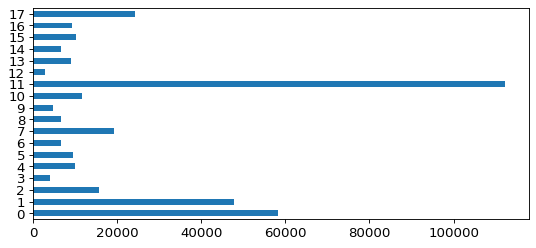

In [20]:
pd.DataFrame(pd.DataFrame({'outputs': list(outputs)})['outputs'].to_list()).sum().plot(kind='barh')

<AxesSubplot:>

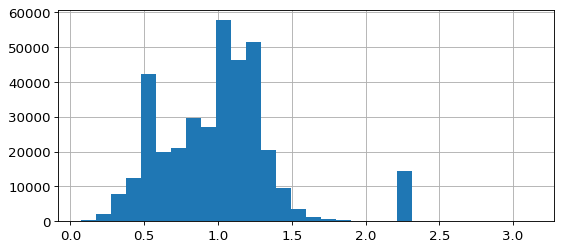

In [21]:
pd.DataFrame(pd.DataFrame({'outputs': list(outputs)})['outputs'].to_list()).sum(axis=1).hist(bins=30)

In [22]:
key_words_detection_df_sample['labels_from_bert'] = pd.DataFrame({'outputs': list(outputs)})['outputs']

In [23]:
key_words_detection_df_sample[['storyId', 'story_wo_html_lower', 'labels_from_bert']]

,storyId,story_wo_html_lower,labels_from_bert
0,urn:newsml:reuters.com:20201223:nNRAdspppv:1,igen networks corp. has joined the t-mobile pa...,"[0.011442418210208416, 0.9739800691604614, 0.0..."
1,urn:newsml:reuters.com:20201222:nGLF4Kt1L3:2,http://filings.ica.int.thomsonreuters.com/fili...,"[0.005342280492186546, 0.21854154765605927, 0...."
2,urn:newsml:reuters.com:20201222:nGLF2DBhZz:2,http://filings.ica.int.thomsonreuters.com/fili...,"[0.005342280492186546, 0.21854154765605927, 0...."
3,urn:newsml:reuters.com:20201221:nBw3VPZ4Qa:1,"\nwfb (bus), anyone? t-mobile turns red rose t...","[0.011911025270819664, 0.9831876158714294, 0.0..."
4,urn:newsml:reuters.com:20201219:nL8N2IY3D9:1,wiederholung vom freitagbundesnetzagentur gibt...,"[0.008577468805015087, 0.5327667593955994, 0.0..."
...,...,...,...
368983,urn:newsml:reuters.com:20210115:nL8N2JQ2VB:7,"adds pfizer comment, backgroundby gwladys fouc...","[0.9657328724861145, 0.004501645918935537, 0.0..."
368984,urn:newsml:reuters.com:20210115:nL8N2JQ380:1,"oslo, 15 stycznia (reuters) - pfizer pfe.n cza...","[0.20398657023906708, 0.021239910274744034, 0...."
368985,urn:newsml:reuters.com:20210115:nL4N2JQ2P2:6,"adds details from ema statement, background on...","[0.01552135031670332, 0.28162068128585815, 0.0..."
368986,urn:newsml:reuters.com:20210115:nL8N2JQ2PM:1,l'ue s'attend à des livraisons limitées jusqu'...,"[0.04312611743807793, 0.048239149153232574, 0...."


In [30]:
key_words_detection_df_sample[['storyId', 'labels_from_bert']]

,storyId,labels_from_bert
0,urn:newsml:reuters.com:20201223:nNRAdspppv:1,"[0.011442418210208416, 0.9739800691604614, 0.0..."
1,urn:newsml:reuters.com:20201222:nGLF4Kt1L3:2,"[0.005342280492186546, 0.21854154765605927, 0...."
2,urn:newsml:reuters.com:20201222:nGLF2DBhZz:2,"[0.005342280492186546, 0.21854154765605927, 0...."
3,urn:newsml:reuters.com:20201221:nBw3VPZ4Qa:1,"[0.011911025270819664, 0.9831876158714294, 0.0..."
4,urn:newsml:reuters.com:20201219:nL8N2IY3D9:1,"[0.008577468805015087, 0.5327667593955994, 0.0..."
...,...,...
368983,urn:newsml:reuters.com:20210115:nL8N2JQ2VB:7,"[0.9657328724861145, 0.004501645918935537, 0.0..."
368984,urn:newsml:reuters.com:20210115:nL8N2JQ380:1,"[0.20398657023906708, 0.021239910274744034, 0...."
368985,urn:newsml:reuters.com:20210115:nL4N2JQ2P2:6,"[0.01552135031670332, 0.28162068128585815, 0.0..."
368986,urn:newsml:reuters.com:20210115:nL8N2JQ2PM:1,"[0.04312611743807793, 0.048239149153232574, 0...."


In [31]:
key_words_detection_df_sample[['storyId', 'labels_from_bert']].to_csv(path_project_folder + 'labbeled_news_by_bert.csv', index=False)

In [17]:
pd.read_csv('data/' + 'labbeled_news_by_bert.csv')

,storyId,labels_from_bert
0,urn:newsml:reuters.com:20201223:nNRAdspppv:1,"[0.011442418210208416, 0.9739800691604614, 0.0..."
1,urn:newsml:reuters.com:20201222:nGLF4Kt1L3:2,"[0.005342280492186546, 0.21854154765605927, 0...."
2,urn:newsml:reuters.com:20201222:nGLF2DBhZz:2,"[0.005342280492186546, 0.21854154765605927, 0...."
3,urn:newsml:reuters.com:20201221:nBw3VPZ4Qa:1,"[0.011911025270819664, 0.9831876158714294, 0.0..."
4,urn:newsml:reuters.com:20201219:nL8N2IY3D9:1,"[0.008577468805015087, 0.5327667593955994, 0.0..."
...,...,...
368983,urn:newsml:reuters.com:20210115:nL8N2JQ2VB:7,"[0.9657328724861145, 0.004501645918935537, 0.0..."
368984,urn:newsml:reuters.com:20210115:nL8N2JQ380:1,"[0.20398657023906708, 0.021239910274744034, 0...."
368985,urn:newsml:reuters.com:20210115:nL4N2JQ2P2:6,"[0.01552135031670332, 0.28162068128585815, 0.0..."
368986,urn:newsml:reuters.com:20210115:nL8N2JQ2PM:1,"[0.04312611743807793, 0.048239149153232574, 0...."
